<a href="https://colab.research.google.com/github/Ajay-user/DataScience/blob/master/Understanding_Stateful_LSTM_Recurrent_Neural_Networks_in_Python_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Utility for plotting

In [2]:
def plot_graph(history, metric):
  plt.plot(history[metric],label=metric)
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend()

https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

A powerful and popular recurrent neural network is the long short-term model network or LSTM.

It is widely used because the architecture overcomes the vanishing and exploding gradient problem that plagues all recurrent neural networks, allowing very large and very deep networks to be created.

Like other recurrent neural networks, LSTM networks maintain state

## Problem Description: Learn the Alphabet

Given a letter of the alphabet, predict the next letter of the alphabet.

This is a simple sequence prediction problem that once understood can be generalized to other sequence prediction problems like time series prediction and sequence classification.

We can now define our dataset, the alphabet. We define the alphabet in uppercase characters for readability.

Neural networks model numbers, so we need to map the letters of the alphabet to integer values. We can do this easily by creating a dictionary (map) of the letter index to the character. We can also create a reverse lookup for converting predictions back into characters to be used later.

# define the raw dataset
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"




In [3]:
# define the raw dataset
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

# create mapping of characters to integers (0-25) and the reverse
char_to_int = {key:val for val, key in enumerate(alphabet)}
int_to_char = {key:val for key, val in enumerate(alphabet)}

### Prepare the dataset
Now we need to create our input and output pairs on which to train our neural network. We can do this by defining an input sequence length, then reading sequences from the input alphabet sequence.

For example we use an input length of 1. Starting at the beginning of the raw input data, we can read off the first letter “A” and the next letter as the prediction “B”. We move along one character and repeat until we reach a prediction of “Z”.






In [4]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 1
dataX=[]
dataY=[]
for i in range(0, len(alphabet)-seq_length):
  seq_in = alphabet[i:i+seq_length]
  seq_out = alphabet[i+seq_length]
  dataX.append([char_to_int[char] for char in seq_in])
  dataY.append(char_to_int[seq_out])
  print(seq_in,'--->',seq_out)

A ---> B
B ---> C
C ---> D
D ---> E
E ---> F
F ---> G
G ---> H
H ---> I
I ---> J
J ---> K
K ---> L
L ---> M
M ---> N
N ---> O
O ---> P
P ---> Q
Q ---> R
R ---> S
S ---> T
T ---> U
U ---> V
V ---> W
W ---> X
X ---> Y
Y ---> Z


### Reshape the data
We need to reshape the NumPy array into a format expected by the LSTM networks, that is [`samples`, `time steps`, `features`].

In [5]:
X = np.reshape(dataX, (len(dataX), seq_length, 1))

print('Shape of input',X.shape)

Shape of input (25, 1, 1)


### Normalize the data
Once reshaped, we can then normalize the input integers to the range 0-to-1, the range of the sigmoid activation functions used by the LSTM network.

In [6]:
# normalize
X = X/float(len(alphabet))

### One-hot-encode the output-var
Finally, we can think of this problem as a sequence classification task, where each of the 26 letters represents a different class. As such, we can convert the output (y) to a one hot encoding, using the Keras built-in function to_categorical().

In [7]:
y = tf.keras.utils.to_categorical(dataY)

## Naive LSTM for Learning One-Char to One-Char Mapping

**Let’s start off by designing a simple LSTM to learn how to predict the next character in the alphabet given the context of just one character**.

We will frame the problem as a random collection of one-letter input to one-letter output pairs. As we will see this is a difficult framing of the problem for the LSTM to learn.

Let’s define an LSTM network with 32 units and an output layer with a softmax activation function for making predictions. Because this is a multi-class classification problem, we can use the log loss function (called “categorical_crossentropy” in Keras), and optimize the network using the ADAM optimization function.

The model is fit over 500 epochs with a batch size of 1.

### Model

In [8]:
one_char_to_one_char_model = tf.keras.Sequential([
                                                  tf.keras.layers.LSTM(units=32, input_shape=(X.shape[1],X.shape[2])),
                                                  tf.keras.layers.Dense(units=y.shape[1], activation='softmax')                                           
])

In [9]:
one_char_to_one_char_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = one_char_to_one_char_model.fit(X, y, batch_size=1, epochs=500, verbose=0)

### Evaluation
After we fit the model we can evaluate and summarize the performance on the entire training dataset.

In [11]:
loss, accuracy = one_char_to_one_char_model.evaluate(X, y, verbose=0)

print('Loss',loss)
print('Model accuracy',accuracy)

Loss 1.701980710029602
Model accuracy 0.800000011920929


### Visualize the performance

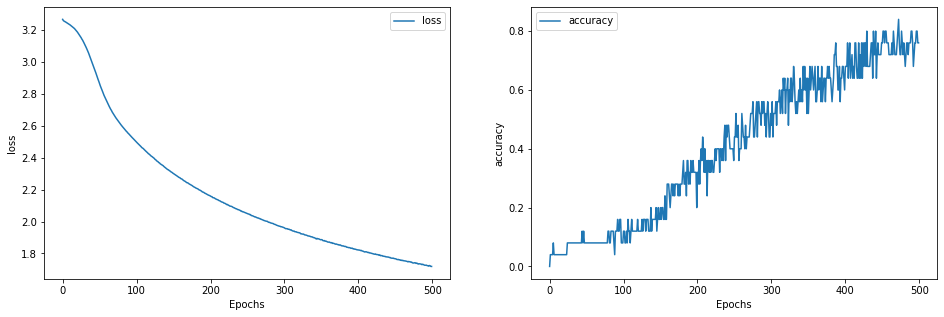

In [12]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plot_graph(history.history, 'loss')
plt.subplot(1,2,2)
plot_graph(history.history, 'accuracy')

### Demonstrate some model prediction

In [13]:
# demonstrate some model prediction
for pattern in dataX:
  # reshape 
  x = np.reshape(pattern, (1, len(pattern) ,1))
  # normalize
  x = x / float(len(alphabet))
  prediction = one_char_to_one_char_model.predict(x, verbose=0)
  index = np.argmax(prediction)
  result = int_to_char[index]
  seq_in = [int_to_char[val] for val in pattern]
  print(seq_in,'-->',result)



['A'] --> B
['B'] --> B
['C'] --> D
['D'] --> E
['E'] --> F
['F'] --> G
['G'] --> H
['H'] --> I
['I'] --> J
['J'] --> K
['K'] --> L
['L'] --> M
['M'] --> N
['N'] --> O
['O'] --> P
['P'] --> Q
['Q'] --> R
['R'] --> S
['S'] --> T
['T'] --> U
['U'] --> W
['V'] --> X
['W'] --> Z
['X'] --> Z
['Y'] --> Z


We can see that this problem is indeed difficult for the network to learn.

**The reason is, the poor LSTM units do not have any context to work with. Each input-output pattern is shown to the network in a random order and the state of the network is reset after each pattern (each batch where each batch contains one pattern)**.

This is abuse of the LSTM network architecture, treating it like a standard multilayer Perceptron.

Next, let’s try a different framing of the problem in order to provide more sequence to the network from which to learn.

## Naive LSTM for a Three-Char Feature Window to One-Char Mapping

A popular approach to adding more context to data for multilayer Perceptrons is to use the window method.

This is where previous steps in the sequence are provided as additional input features to the network. We can try the same trick to provide more context to the LSTM network.

Here, we increase the sequence length from 1 to 3, for example:

Again, this creates input-output pairs that look like:

<br>
ABC -> D<br>
BCD -> E<br>
CDE -> F<br>
DEF -> G<br>
<br>

Each element in the sequence is then provided as a new input feature to the network. This requires a modification of how the input sequences reshaped

### Prepare the dataset

In [14]:
dataX=[]
dataY=[]
seq_length = 3
for i in range(len(alphabet)-seq_length):
  seq_in = alphabet[i:i+seq_length]
  seq_out = alphabet[i+seq_length]
  dataX.append([char_to_int[pattern] for pattern in seq_in])
  dataY.append(char_to_int[seq_out])
  print(seq_in,'-->',seq_out)

ABC --> D
BCD --> E
CDE --> F
DEF --> G
EFG --> H
FGH --> I
GHI --> J
HIJ --> K
IJK --> L
JKL --> M
KLM --> N
LMN --> O
MNO --> P
NOP --> Q
OPQ --> R
PQR --> S
QRS --> T
RST --> U
STU --> V
TUV --> W
UVW --> X
VWX --> Y
WXY --> Z


### Reshape the data

In [15]:
X = np.reshape(dataX, (len(dataX), 1, seq_length))

print('Shape of input',X.shape)

Shape of input (23, 1, 3)


### Normalize the data

In [16]:
X = X / float(len(alphabet))

### One-hot-encode the output

In [17]:
y = tf.keras.utils.to_categorical(dataY)

### Model

In [18]:
three_char_feature_to_one_char_model = tf.keras.Sequential([
                                                    tf.keras.layers.LSTM(units=32, input_shape=(X.shape[1], X.shape[2])),
                                                    tf.keras.layers.Dense(units=y.shape[1], activation='softmax')
])

In [19]:
three_char_feature_to_one_char_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = three_char_feature_to_one_char_model.fit(X, y, epochs=500, batch_size=1, verbose=0)

### Evaluation

In [21]:
loss, accuracy = three_char_feature_to_one_char_model.evaluate(X, y, verbose=0)

print('Loss',loss)
print('Model accuracy',accuracy)

Loss 1.5642001628875732
Model accuracy 0.8695651888847351


### Visualize the performance

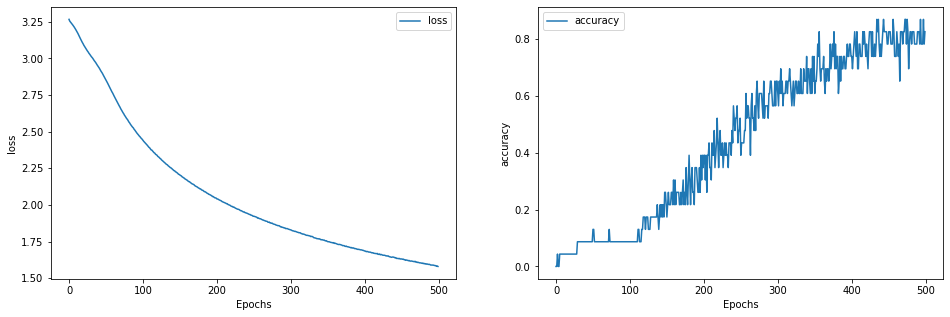

In [22]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plot_graph(history.history, 'loss')
plt.subplot(1,2,2)
plot_graph(history.history, 'accuracy')

### Demonstrate some model prediction

In [23]:
for pattern in dataX:
  # reshape
  x = np.reshape(pattern, (1, 1, len(pattern)))
  # normalize
  x = x/float(len(alphabet))
  prediction = three_char_feature_to_one_char_model.predict(x, verbose=0)
  index = np.argmax(prediction)
  result = int_to_char[index]
  seq_in = [int_to_char[val] for val in pattern]
  print(seq_in,'-->',result)

['A', 'B', 'C'] --> D
['B', 'C', 'D'] --> E
['C', 'D', 'E'] --> F
['D', 'E', 'F'] --> G
['E', 'F', 'G'] --> H
['F', 'G', 'H'] --> I
['G', 'H', 'I'] --> J
['H', 'I', 'J'] --> K
['I', 'J', 'K'] --> L
['J', 'K', 'L'] --> M
['K', 'L', 'M'] --> N
['L', 'M', 'N'] --> O
['M', 'N', 'O'] --> P
['N', 'O', 'P'] --> Q
['O', 'P', 'Q'] --> R
['P', 'Q', 'R'] --> S
['Q', 'R', 'S'] --> T
['R', 'S', 'T'] --> U
['S', 'T', 'U'] --> V
['T', 'U', 'V'] --> X
['U', 'V', 'W'] --> Z
['V', 'W', 'X'] --> Z
['W', 'X', 'Y'] --> Z


We can see a small lift in performance that may or may not be real. This is a simple problem that we were still not able to learn with LSTMs even with the window method.

Again, this is a misuse of the LSTM network by a poor framing of the problem. **Indeed, the sequences of letters are time steps of one feature rather than one time step of separate features. We have given more context to the network, but not more sequence as it expected**.

In the next section, we will give more context to the network in the form of time steps.

## Naive LSTM for a Three-Char Time Step Window to One-Char Mapping

In Keras, the intended use of LSTMs is to provide context in the form of time steps, rather than windowed features like with other network types.

We can take our first example and simply change the sequence length from 1 to 3.

seq_length = 3

Again, this creates input-output pairs that look like:

<br>
ABC -> D<br>
BCD -> E<br>
CDE -> F<br>
DEF -> G<br>
<br>

The difference is that the reshaping of the input data takes the sequence as a time step sequence of one feature, rather than a single time step of multiple features.

### Prepare the dataset

In [24]:
dataX=[]
dataY=[]
seq_length = 3
for i in range(len(alphabet)-seq_length):
  seq_in = alphabet[i:i+seq_length]
  seq_out = alphabet[i+seq_length]
  dataX.append([char_to_int[pattern] for pattern in seq_in])
  dataY.append(char_to_int[seq_out])
  print(seq_in,'-->',seq_out)

ABC --> D
BCD --> E
CDE --> F
DEF --> G
EFG --> H
FGH --> I
GHI --> J
HIJ --> K
IJK --> L
JKL --> M
KLM --> N
LMN --> O
MNO --> P
NOP --> Q
OPQ --> R
PQR --> S
QRS --> T
RST --> U
STU --> V
TUV --> W
UVW --> X
VWX --> Y
WXY --> Z


### Reshape the data

In [25]:
X = np.reshape(dataX, (len(dataX), seq_length, 1))

print('Shape of input',X.shape)

Shape of input (23, 3, 1)


### Normalize the dataset

In [26]:
X = X / float(len(alphabet))

### One-hot-encode the output

In [27]:
y = tf.keras.utils.to_categorical(dataY)

### Model

In [28]:
three_char_Timestep_to_one_char_model = tf.keras.Sequential([
                                                             tf.keras.layers.LSTM(units=32, input_shape=(X.shape[1], X.shape[2])),
                                                             tf.keras.layers.Dense(units=y.shape[1], activation='softmax')
])

In [29]:
three_char_Timestep_to_one_char_model.compile(optimizer='adam',
                                              loss='categorical_crossentropy',
                                              metrics=['accuracy'])

In [30]:
history = three_char_Timestep_to_one_char_model.fit(X, y, epochs=500, batch_size=1, verbose=0)

### Evaluation

In [31]:
loss, accuracy = three_char_Timestep_to_one_char_model.evaluate(X, y, verbose=0)

print('Loss',loss)
print('Model accuracy',accuracy)

Loss 0.2275867462158203
Model accuracy 1.0


### Visualize the performance

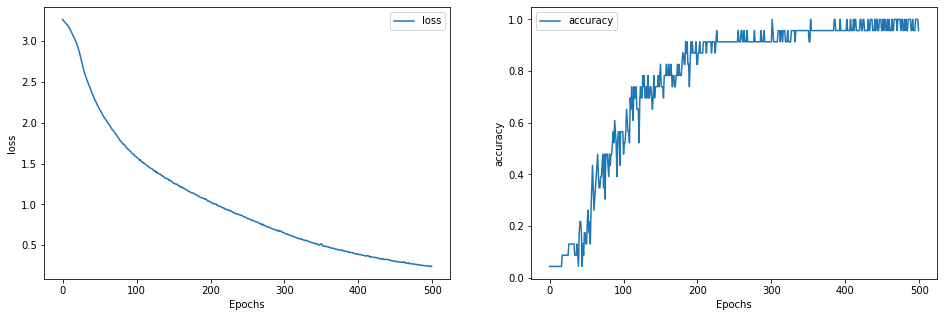

In [32]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plot_graph(history.history, 'loss')
plt.subplot(1,2,2)
plot_graph(history.history, 'accuracy')

### Demonstrate some model performance

In [33]:
for pattern in dataX:
  # reshape
  x = np.reshape(pattern, (1, len(pattern), 1))
  # normalize
  x = x / float(len(alphabet))
  prediction = three_char_Timestep_to_one_char_model.predict(x, verbose=0)
  index = np.argmax(prediction)
  result = int_to_char[index]
  seq_in = [int_to_char[val] for val in pattern]
  print(seq_in,'-->',result)

['A', 'B', 'C'] --> D
['B', 'C', 'D'] --> E
['C', 'D', 'E'] --> F
['D', 'E', 'F'] --> G
['E', 'F', 'G'] --> H
['F', 'G', 'H'] --> I
['G', 'H', 'I'] --> J
['H', 'I', 'J'] --> K
['I', 'J', 'K'] --> L
['J', 'K', 'L'] --> M
['K', 'L', 'M'] --> N
['L', 'M', 'N'] --> O
['M', 'N', 'O'] --> P
['N', 'O', 'P'] --> Q
['O', 'P', 'Q'] --> R
['P', 'Q', 'R'] --> S
['Q', 'R', 'S'] --> T
['R', 'S', 'T'] --> U
['S', 'T', 'U'] --> V
['T', 'U', 'V'] --> W
['U', 'V', 'W'] --> X
['V', 'W', 'X'] --> Y
['W', 'X', 'Y'] --> Z


We can see that the model learns the problem perfectly as evidenced by the model evaluation and the example predictions.

But it has learned a simpler problem. Specifically, it has learned to predict the next letter from a sequence of three letters in the alphabet. It can be shown any random sequence of three letters from the alphabet and predict the next letter.

It can not actually enumerate the alphabet. I expect that a larger enough multilayer perception network might be able to learn the same mapping using the window method.

The LSTM networks are stateful. They should be able to learn the whole alphabet sequence, but by default the Keras implementation resets the network state after each training batch.

## LSTM State Within A Batch
The Keras implementation of LSTMs resets the state of the network after each batch.

This suggests that if we had a batch size large enough to hold all input patterns and if all the input patterns were ordered sequentially, that the LSTM could use the context of the sequence within the batch to better learn the sequence.

We can demonstrate this easily by modifying the first example for learning a one-to-one mapping and increasing the batch size from 1 to the size of the training dataset.

Additionally, Keras shuffles the training dataset before each training epoch. To ensure the training data patterns remain sequential, we can disable this shuffling.

The network will learn the mapping of characters using the the within-batch sequence, but this context will not be available to the network when making predictions. We can evaluate both the ability of the network to make predictions randomly and in sequence.

### Prepare the dataset

In [43]:
dataX=[]
dataY=[]
seq_length = 1
for i in range(len(alphabet)-seq_length):
  seq_in = alphabet[i:i+seq_length]
  seq_out = alphabet[i+seq_length]
  dataX.append([char_to_int[pattern] for pattern in seq_in])
  dataY.append(char_to_int[seq_out])
  print(seq_in,'-->',seq_out)

A --> B
B --> C
C --> D
D --> E
E --> F
F --> G
G --> H
H --> I
I --> J
J --> K
K --> L
L --> M
M --> N
N --> O
O --> P
P --> Q
Q --> R
R --> S
S --> T
T --> U
U --> V
V --> W
W --> X
X --> Y
Y --> Z


In [53]:
# convert list of lists to array and pad sequences if needed
X = tf.keras.preprocessing.sequence.pad_sequences(dataX, maxlen=seq_length, dtype='float32')

### Reshape the dataset

In [54]:
X = np.reshape(X, (len(dataX), seq_length, 1))

print('Shape of input',X.shape)

Shape of input (25, 1, 1)


### Normalize the dataset

In [55]:
X = X / float(len(alphabet))

### One-hot-encode the output-var

In [57]:
y = tf.keras.utils.to_categorical(dataY)

### Model

In [64]:
lstm_state_within_batch_model = tf.keras.Sequential([
                                                     tf.keras.layers.LSTM(units=16, input_shape=(X.shape[1],X.shape[2])),
                                                     tf.keras.layers.Dense(units=y.shape[1], activation='softmax')
])

In [65]:
lstm_state_within_batch_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
history = lstm_state_within_batch_model.fit(X, y, epochs=5000, batch_size=len(dataX), verbose=0, shuffle=False)

### Evaluation

In [68]:
loss, accuracy = lstm_state_within_batch_model.evaluate(X, y, verbose=0)

print('Loss',loss)
print('Model Accuracy', accuracy)

Loss 0.9226238131523132
Model Accuracy 1.0


### Visualize the performance

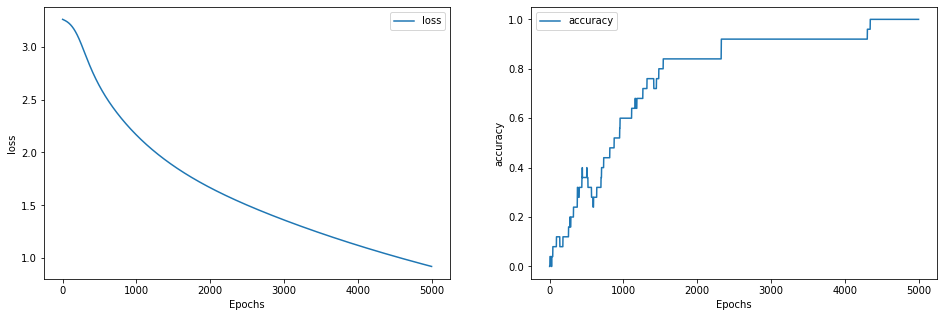

In [69]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plot_graph(history.history, 'loss')
plt.subplot(1,2,2)
plot_graph(history.history, 'accuracy')

### Demonstrate some model performance

In [70]:
for pattern in dataX:
  # reshape
  x = np.reshape(pattern, (1, len(pattern), 1))
  # normalize
  x = x / float(len(alphabet))
  prediction = lstm_state_within_batch_model.predict(x, verbose=0)
  index = np.argmax(prediction)
  result = int_to_char[index]
  seq_in = [int_to_char[val] for val in pattern]
  print(seq_in,'-->',result)

['A'] --> B
['B'] --> C
['C'] --> D
['D'] --> E
['E'] --> F
['F'] --> G
['G'] --> H
['H'] --> I
['I'] --> J
['J'] --> K
['K'] --> L
['L'] --> M
['M'] --> N
['N'] --> O
['O'] --> P
['P'] --> Q
['Q'] --> R
['R'] --> S
['S'] --> T
['T'] --> U
['U'] --> V
['V'] --> W
['W'] --> X
['X'] --> Y
['Y'] --> Z


In [72]:
# demonstrate predicting random patterns
print("Test a Random Pattern:")
for i in range(0,20):
  pattern_index = np.random.randint(len(dataX))
  pattern = dataX[pattern_index]
  # reshape
  x = np.reshape(pattern, (1, len(pattern), 1))
  # normalize
  x = x / float(len(alphabet))
  prediction = lstm_state_within_batch_model.predict(x, verbose=0)
  index = np.argmax(prediction)
  result = int_to_char[index]
  seq_in = [int_to_char[val] for val in pattern]
  print(seq_in,'-->',result)

Test a Random Pattern:
['X'] --> Y
['V'] --> W
['K'] --> L
['Y'] --> Z
['W'] --> X
['F'] --> G
['F'] --> G
['D'] --> E
['J'] --> K
['N'] --> O
['Q'] --> R
['P'] --> Q
['I'] --> J
['A'] --> B
['D'] --> E
['S'] --> T
['W'] --> X
['A'] --> B
['G'] --> H
['O'] --> P


As we expected, the network is able to use the within-sequence context to learn the alphabet, achieving 100% accuracy on the training data.

Importantly, the network can make accurate predictions for the next letter in the alphabet for randomly selected characters. Very impressive.

## Stateful LSTM for a One-Char to One-Char Mapping
We have seen that we can break-up our raw data into fixed size sequences and that this representation can be learned by the LSTM, but only to learn random mappings of 3 characters to 1 character.

We have also seen that we can pervert batch size to offer more sequence to the network, but only during training.

Ideally, we want to expose the network to the entire sequence and let it learn the inter-dependencies, rather than us define those dependencies explicitly in the framing of the problem.

We can do this in Keras by making the LSTM layers stateful and manually resetting the state of the network at the end of the epoch, which is also the end of the training sequence.

This is truly how the LSTM networks are intended to be used.

We first need to define our LSTM layer as stateful. In so doing, we must explicitly specify the batch size as a dimension on the input shape. This also means that when we evaluate the network or make predictions, we must also specify and adhere to this same batch size. This is not a problem now as we are using a batch size of 1. This could introduce difficulties when making predictions where the batch size is not one as predictions will need to be made in batch and in sequence.


`batch_size` = 1

`model`.`add`(`LSTM`(50, `batch_input_shape`=(`batch_size`, `X.shape[1]`, `X.shape[2]`), `stateful`=True))`

An important difference in training the stateful LSTM is that we train it manually one epoch at a time and reset the state after each epoch. We can do this in a `for loop`. Again, we do not shuffle the input, preserving the sequence in which the input training data was created


`for` i `in` range(300):<br>
	`model`.`fit`(X, y, `epochs=1`, `batch_size=batch_size`, `verbose=2`, `shuffle=False`)<br>
	`model`.`reset_states()`<br>
  <br>

As mentioned, we specify the batch size when evaluating the performance of the network on the entire training dataset.


**summarize performance of the model**

`scores` = `model`.`evaluate`(X, y, `batch_size=batch_size`, `verbose`=0)<br>
`model`.`reset_states()`<br>
`print`("Model Accuracy: %.2f%%" % (scores[1]*100))

Finally, we can demonstrate that the network has indeed learned the entire alphabet. We can seed it with the first letter “A”, request a prediction, feed the prediction back in as an input, and repeat the process all the way to “Z”.

### Prepare the dataset

In [73]:
dataX=[]
dataY=[]
seq_length = 1
for i in range(len(alphabet)-seq_length):
  seq_in = alphabet[i:i+seq_length]
  seq_out = alphabet[i+seq_length]
  dataX.append([char_to_int[pattern] for pattern in seq_in])
  dataY.append(char_to_int[seq_out])
  print(seq_in,'-->',seq_out)

A --> B
B --> C
C --> D
D --> E
E --> F
F --> G
G --> H
H --> I
I --> J
J --> K
K --> L
L --> M
M --> N
N --> O
O --> P
P --> Q
Q --> R
R --> S
S --> T
T --> U
U --> V
V --> W
W --> X
X --> Y
Y --> Z


### Reshape the dataset

In [75]:
X = np.reshape(dataX, (len(dataX), seq_length, 1))

print('Shape of input',X.shape)

Shape of input (25, 1, 1)


### Normalize the dataset

In [76]:
X = X / float(len(alphabet))

### One-hot-encode the output-var

In [77]:
y = tf.keras.utils.to_categorical(dataY)

### Model

In [92]:
batch_size = 1

stateful_lstm_model = tf.keras.Sequential([
                                           tf.keras.layers.LSTM(units=50,
                                                                batch_input_shape=(batch_size, X.shape[1], X.shape[2]),
                                                                stateful=True),
                                           tf.keras.layers.Dense(units=y.shape[1], activation='softmax')
])

In [93]:
stateful_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [94]:
loss_ = []
accuracy_ = []
for i in range(300):
  history = stateful_lstm_model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
  loss_.append(history.history['loss'])
  accuracy_.append(history.history['accuracy'])
  stateful_lstm_model.reset_states()

### Evaluation

In [95]:
loss, accuracy = stateful_lstm_model.evaluate(X, y, batch_size=batch_size, verbose=0)
stateful_lstm_model.reset_states()
print('Loss',loss)
print('Model Accuracy', accuracy)

Loss 0.009655393660068512
Model Accuracy 1.0


### Visualize the performance

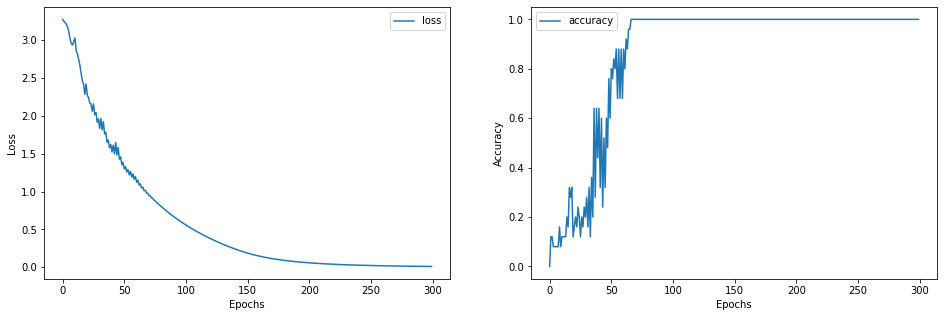

In [101]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(range(300), loss_, label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(300), accuracy_, label='accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Demonstrate some model predictions

In [107]:
# demonstrate some model predictions
seed = [char_to_int[alphabet[0]]]
for i in range(len(alphabet)-1):
  # reshape
  x = np.reshape(seed, (1, len(seed), 1))
  # normalize
  x = x / float(len(alphabet))
  prediction = stateful_lstm_model.predict(x, verbose=0)
  index = np.argmax(prediction)
  result = int_to_char[index]
  seq_in = int_to_char[seed[0]]
  seed = [index]
  print(seq_in,'-->',result)

stateful_lstm_model.reset_states()

A --> B
B --> C
C --> D
D --> E
E --> F
F --> G
G --> H
H --> I
I --> J
J --> K
K --> L
L --> M
M --> N
N --> O
O --> P
P --> Q
Q --> R
R --> S
S --> T
T --> U
U --> V
V --> W
W --> X
X --> Y
Y --> Z


In [110]:
# demonstrate a random starting point
seed = [char_to_int["K"]]
for i in range(5):
  # reshape
  x = np.reshape(seed, (1, len(seed), 1))
  # normalize
  x = x / float(len(alphabet))
  prediction = stateful_lstm_model.predict(x, verbose=0)
  index = np.argmax(prediction)
  result = int_to_char[index]
  seq_in = int_to_char[seed[0]]
  seed = [index]
  print(seq_in,'-->',result)

stateful_lstm_model.reset_states()

K --> B
B --> C
C --> D
D --> E
E --> F


We can see that the network has memorized the entire alphabet perfectly. It used the context of the samples themselves and learned whatever dependency it needed to predict the next character in the sequence.

We can also see that if we seed the network with the first letter, that it can correctly rattle off the rest of the alphabet.

We can also see that it has only learned the full alphabet sequence and that from a cold start. When asked to predict the next letter from “K” that it predicts “B” and falls back into regurgitating the entire alphabet.

To truly predict “K” the state of the network would need to be warmed up iteratively fed the letters from “A” to “J”. This tells us that we could achieve the same effect with a “stateless” LSTM by preparing training data like:

<br>
---a -> b<br>
--ab -> c<br>
-abc -> d<br>
abcd -> e<br>
<br>

Where the input sequence is fixed at 25 (a-to-y to predict z) and patterns are prefixed with zero-padding.

Finally, this raises the question of training an LSTM network using variable length input sequences to predict the next character.

## LSTM with Variable-Length Input to One-Char Output
In the previous section, we discovered that the Keras “stateful” LSTM was really only a shortcut to replaying the first n-sequences, but didn’t really help us learn a generic model of the alphabet.

In this section we explore a variation of the “stateless” LSTM that learns random subsequences of the alphabet and an effort to build a model that can be given arbitrary letters or subsequences of letters and predict the next letter in the alphabet.

Firstly, we are changing the framing of the problem. To simplify we will define a maximum input sequence length and set it to a small value like 5 to speed up training. This defines the maximum length of subsequences of the alphabet which will be drawn for training. In extensions, this could just as set to the full alphabet (26) or longer if we allow looping back to the start of the sequence.

We also need to define the number of random sequences to create, in this case 1000. This too could be more or less. I expect less patterns are actually required.

### Prepare the dataset

In [119]:
# prepare the dataset of input to output pairs encoded as integers
num_inputs = 1000
max_len = 5
dataX=[]
dataY=[]
for i in range(num_inputs):
  start = np.random.randint(len(alphabet)-2)
  end = np.random.randint(start, min(start+max_len, len(alphabet)-1))
  seq_in = alphabet[start:end+1]
  seq_out = alphabet[end+1]
  dataX.append([char_to_int[pattern] for pattern in seq_in])
  dataY.append(char_to_int[seq_out])


In [125]:
# Running this code in the broader context will create input patterns that look like the following:
for i in range(5):
  print([int_to_char[val] for val in dataX[i]],'-->',int_to_char[dataY[i]])

['T', 'U'] --> V
['L', 'M', 'N', 'O'] --> P
['J', 'K', 'L', 'M'] --> N
['N'] --> O
['I', 'J', 'K'] --> L


The input sequences vary in length between 1 and max_len and therefore require zero padding. Here, we use left-hand-side (prefix) padding with the Keras built in pad_sequences() function.

In [126]:
X = tf.keras.preprocessing.sequence.pad_sequences(dataX, max_len, dtype='float32')

### Reshape the dataset

In [127]:
X = np.reshape(X, (X.shape[0], max_len, 1))

print('Shape of input', X.shape)

Shape of input (1000, 5, 1)


### Normalize the dataset

In [128]:
X = X / float(len(alphabet))

### One-hot-encode the output-var

In [129]:
y = tf.keras.utils.to_categorical(dataY)

### Model

In [130]:
LSTM_with_Variable_Length_Input_to_One_Char_Output_model = tf.keras.Sequential([
                                                                                
                      tf.keras.layers.LSTM(units=32, input_shape=(X.shape[1], X.shape[2])),
                      tf.keras.layers.Dense(y.shape[1], activation='softmax')
])

In [131]:
LSTM_with_Variable_Length_Input_to_One_Char_Output_model.compile(optimizer='adam',
                                                                 loss='categorical_crossentropy',
                                                                 metrics=['accuracy'])

In [132]:
history = LSTM_with_Variable_Length_Input_to_One_Char_Output_model.fit(X, y, epochs=500, batch_size=1, verbose=0)

### Evaluation

In [133]:
loss, accuracy = LSTM_with_Variable_Length_Input_to_One_Char_Output_model.evaluate(X, y, verbose=0)

print('Loss',loss)
print('Model Accuracy', accuracy)

Loss 0.10381659865379333
Model Accuracy 0.9879999756813049


### Visualize the performance

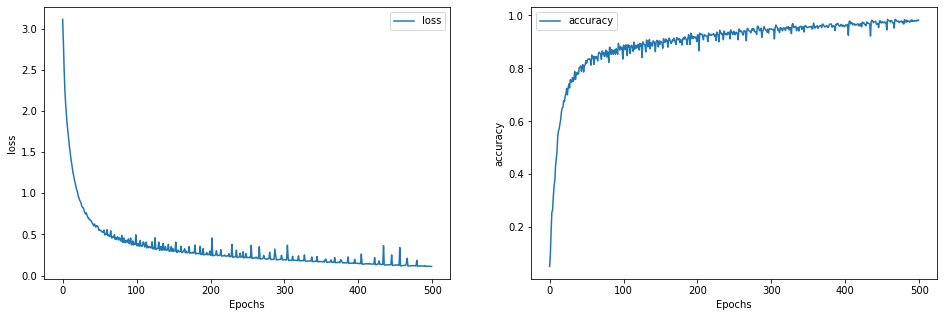

In [134]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plot_graph(history.history, 'loss')
plt.subplot(1,2,2)
plot_graph(history.history, 'accuracy')

### Demonstrate some model prediction

In [138]:
# demonstrate some model prediction
for i in range(20):
  pattern_index = np.random.randint(len(dataX))
  pattern = dataX[pattern_index]
  # zero-padding
  x = tf.keras.preprocessing.sequence.pad_sequences([pattern], max_len, dtype='float32')
  # reshape
  x = np.reshape(x,(1, max_len, 1))
  # normalize
  x = x / float(len(alphabet))
  prediction =  LSTM_with_Variable_Length_Input_to_One_Char_Output_model.predict(x, verbose=0)
  index = np.argmax(prediction)
  result = int_to_char[index]
  seq_in = [int_to_char[val] for val in pattern]
  print(seq_in,'-->', result)

['C', 'D', 'E', 'F', 'G'] --> H
['L', 'M', 'N', 'O', 'P'] --> Q
['I'] --> J
['S', 'T', 'U'] --> V
['E', 'F', 'G', 'H', 'I'] --> J
['I', 'J'] --> K
['D', 'E', 'F', 'G'] --> H
['V', 'W', 'X'] --> Y
['C', 'D'] --> E
['U', 'V'] --> W
['P'] --> Q
['X'] --> Y
['P', 'Q'] --> R
['G', 'H', 'I', 'J'] --> K
['B', 'C'] --> D
['D', 'E', 'F', 'G', 'H'] --> I
['Q', 'R', 'S'] --> T
['L', 'M', 'N'] --> O
['K'] --> L
['J', 'K', 'L', 'M'] --> N
